    
- [X] idh e  a taxa de admissão empregos precisam estar parecidos

- [X] mostrar matematicamente a linha de raciciono do tratamento (ex smote , e etc) explicar o que são e como funcionama

- [X] realizar analise so de quem tem mais de 100 mil habitantes 

- [X] separa os pequenos metrópoles medios(fazer uma analise de cada um) e analisar para saber quais parâmetros definem as analises

- [   ] ver quais colunas e linhas estão dando errados ( Procurar overlays? )


## 1. Importação das Bibliotecas e Carregamento dos Dados

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


# Configurações de visualização
plt.style.use('seaborn')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)



/tmp/ipykernel_65434/36808177.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
# Carregar os dados
df = pd.read_excel('/home/fause/ML-Transportes/Dados/analiseestatistica_indicadores2.xlsx') 
print("Dimensões do dataset:", df.shape)
df.head()



Dimensões do dataset: (5570, 27)


,UF,Estado,codigo_ibge,Integrado ao SNT,Sinistros,Z-score Sinistros,População,Z-score população,Soma da Arrecadação 2018-2023,Z-score Arrecadação,PIB,Z-score PIB,PIB per capita,Z-score PIB per capita,Taxa de alfabetização +15 anos,Tx de Alfabetização +15 anos,Z-score Tx Afabetização,IDHM,Z-score IDHM,Taxa de Admissão em Empregos,300,Taxa de Óbitos/100 mil habitantes,Z-score Tx óbito/100 mil hab,% de Óbitos/Sinistros,Z-score Óbitos/Sinistros,area_km2,km_rodovias_federais
0,RO,Rondônia,1100015,Não,1102,-0.006384,21494,-0.072467,3.291565e+09,-0.076026,2.620769e+08,-0.058931,12193.024937,0.018950,91.59,0.9159,0.448016,0.641,-0.217690,0.509897,-0.094854,162.836140,1.001660,3.176044,-0.600753,7067.127,0.000000
1,RO,Rondônia,1100023,Sim,5622,0.453483,96833,0.292338,1.718637e+10,0.164665,1.364694e+09,0.090208,14093.271715,0.169636,94.08,0.9408,0.777358,0.702,0.567787,0.505000,-0.172360,171.429162,1.122970,2.952686,-0.607705,4426.143,77.806543
2,RO,Rondônia,1100031,Não,185,-0.099680,5351,-0.150634,1.672614e+09,-0.104070,6.961111e+07,-0.084964,13008.991590,0.083655,89.82,0.8982,0.213906,0.650,-0.101800,0.515403,-0.007693,224.257148,1.868761,6.486486,-0.497720,1314.352,0.000000
3,RO,Rondônia,1100049,Sim,5957,0.487566,86887,0.244178,1.279220e+10,0.088548,1.186494e+09,0.066105,13655.599698,0.134930,93.71,0.9371,0.728420,0.718,0.773814,0.511808,-0.064596,159.977902,0.961309,2.333389,-0.626980,3793.000,51.712641
4,RO,Rondônia,1100056,Não,732,-0.044028,15890,-0.099602,3.614702e+09,-0.070429,2.220212e+08,-0.064349,13972.384456,0.160050,92.15,0.9215,0.522085,0.692,0.439020,0.500262,-0.247362,195.091252,1.457016,4.234973,-0.567796,2783.297,29.154767


In [4]:
df.dropna(inplace=True)
print(df[['area_km2', 'km_rodovias_federais']].isnull().sum())

area_km2                0
km_rodovias_federais    0
dtype: int64


## 3. Preparação dos Dados e Modelagem

In [ ]:
# Função de categorização já aplicada
def categorizar_populacao(pop):
    if pop < 20000:
        return 'Pequeno'
    elif opp < 100000:
        return 'Médio'
    elif pop < 500000:
        return 'Grande'
    else:
        return 'Metrópole'

df['Porte'] = df['População'].apply(categorizar_populacao)


In [6]:
# Features e target
features = [
     'Sinistros','PIB per capita', 'Tx de Alfabetização +15 anos',
    'Taxa de Admissão em Empregos', 'IDHM',
    'Taxa de Óbitos/100 mil habitantes', '% de Óbitos/Sinistros',
    'area_km2', 'km_rodovias_federais'
]
df['Integrado ao SNT'] = df['Integrado ao SNT'].map({'Sim': 1, 'Não': 0})

### 3.1 Metropole (Modelo)

In [7]:
df_metropole = df[df['Porte'] == 'Metrópole']

In [8]:
# Definindo X e y
X_metropole = df_metropole[features]
y_metropole = df_metropole['Integrado ao SNT']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_metropole, y_metropole, test_size=0.2, random_state=42)

# Pré-processamento
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Balanceamento com SMOTE

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# Exibir a contagem de valores com os nomes das classes
print("Contagem de valores em y_train:")
for classe, quantidade in y_train.value_counts().items():
    print(f"Classe {classe}: {quantidade}")

Contagem de valores em y_train:
Classe 1: 32


In [9]:
# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação - Metrópole:")
print(classification_report(y_test, y_pred))


Relatório de Classificação - Metrópole:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



/home/fause/ML-Transportes/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### 3.1 Metropole (analise de features)

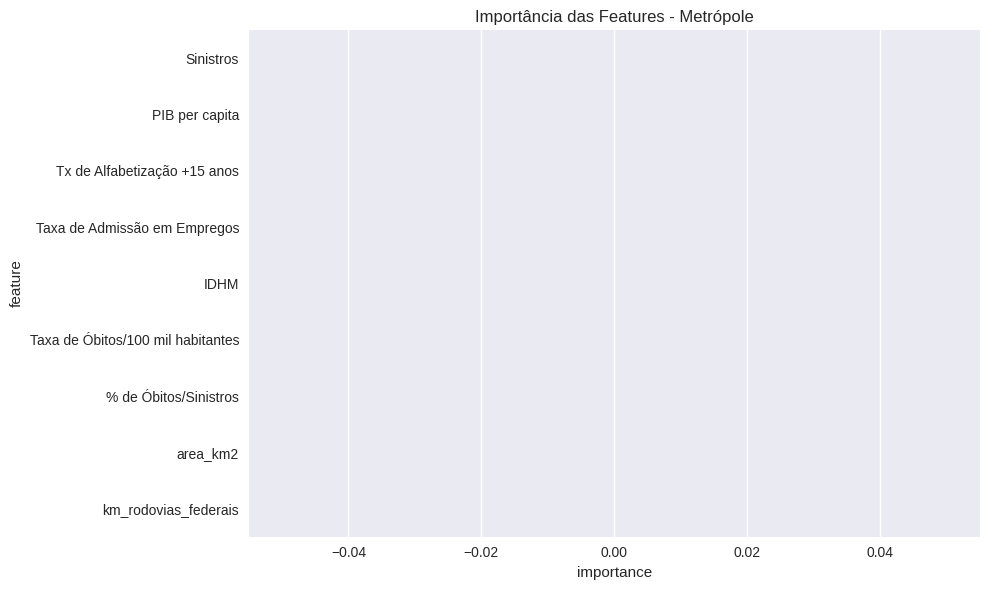

In [10]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features - Metrópole')
plt.tight_layout()
plt.show()

### 3.2 Grande

In [11]:
# Filtrando apenas municípios do tipo "Grande"
df_grande = df[df['Porte'] == 'Grande']

In [12]:

# Definindo X e y
X_grande = df_grande[features]
y_grande = df_grande['Integrado ao SNT']

In [13]:


# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_grande, y_grande, test_size=0.2, random_state=42)

# Pré-processamento
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)



In [14]:
# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação - Grande:")
print(classification_report(y_test, y_pred))



Relatório de Classificação - Grande:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        56

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



/home/fause/ML-Transportes/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


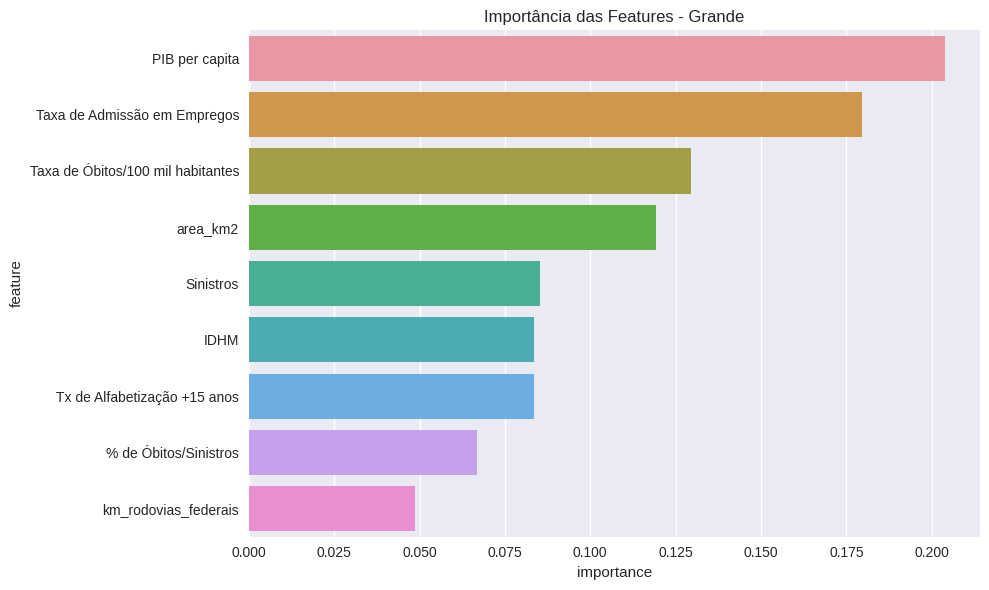

In [15]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features - Grande')
plt.tight_layout()
plt.show()

### 3.3 Médio 

In [16]:
# Filtrando apenas municípios do tipo "Médio"
df_medio = df[df['Porte'] == 'Médio']

In [17]:
# Definindo X e y
X_medio = df_medio[features]
y_medio = df_medio['Integrado ao SNT']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_medio, y_medio, test_size=0.2, random_state=42)

# Pré-processamento
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Contar o número de "Sim" e "Não" na coluna 'Integrado ao SNT'
contagem = df['Integrado ao SNT'].value_counts()

# Exibir os resultados
print("Contagem de valores na coluna 'Integrado ao SNT':")
for valor, quantidade in contagem.items():
    print(f"{valor}: {quantidade}")

Contagem de valores na coluna 'Integrado ao SNT':
0: 3589
1: 1889


In [18]:
# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [19]:
# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação - Médio:")
print(classification_report(y_test, y_pred))


Relatório de Classificação - Médio:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       118
           1       0.79      0.77      0.78       159

    accuracy                           0.75       277
   macro avg       0.74      0.74      0.74       277
weighted avg       0.75      0.75      0.75       277



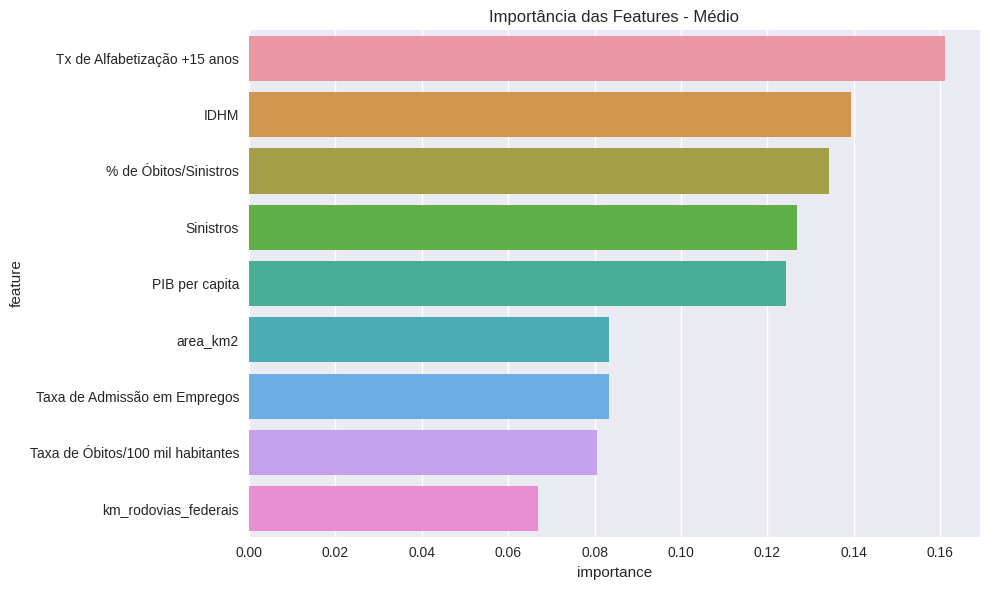

In [20]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features - Médio')
plt.tight_layout()
plt.show()

### 3.2 Pequeno

In [21]:
# Filtrando apenas municípios do tipo "Pequeno"
df_pequeno = df[df['Porte'] == 'Pequeno']

In [22]:
# Definindo X e y
X_pequeno = df_pequeno[features]
y_pequeno = df_pequeno['Integrado ao SNT']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_pequeno, y_pequeno, test_size=0.2, random_state=42)

# Pré-processamento
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [23]:
# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)



In [24]:
# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação - Pequeno:")
print(classification_report(y_test, y_pred))


Relatório de Classificação - Pequeno:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       622
           1       0.64      0.66      0.65       134

    accuracy                           0.87       756
   macro avg       0.78      0.79      0.79       756
weighted avg       0.88      0.87      0.87       756



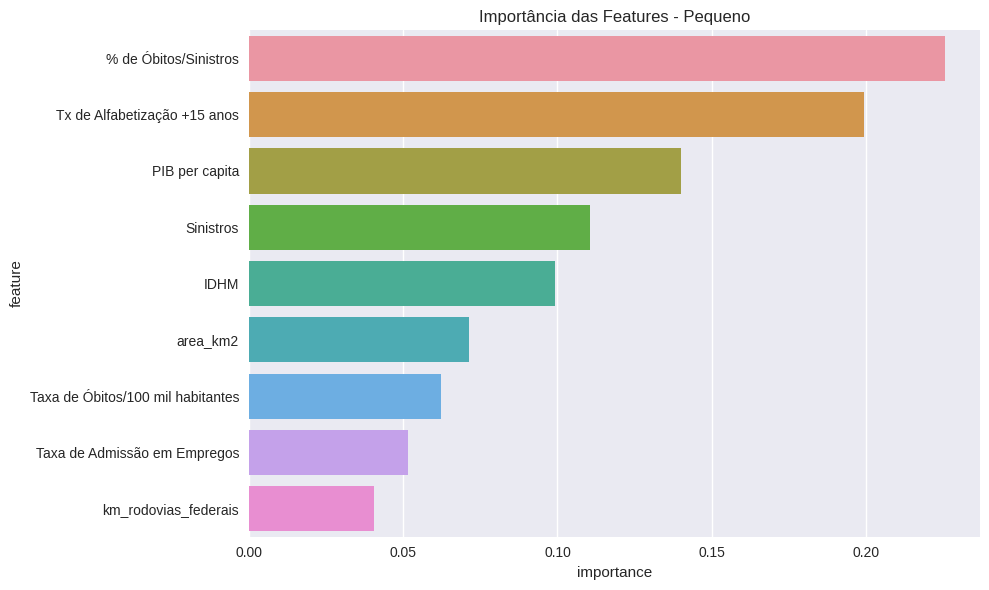

In [25]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features - Pequeno')
plt.tight_layout()
plt.show()

Contagem de 'Sim' e 'Não' por porte do município:
Integrado ao SNT     0    1
Porte                      
Grande               3  274
Metrópole            0   41
Médio              521  861
Pequeno           3065  713


<Figure size 1000x600 with 0 Axes>

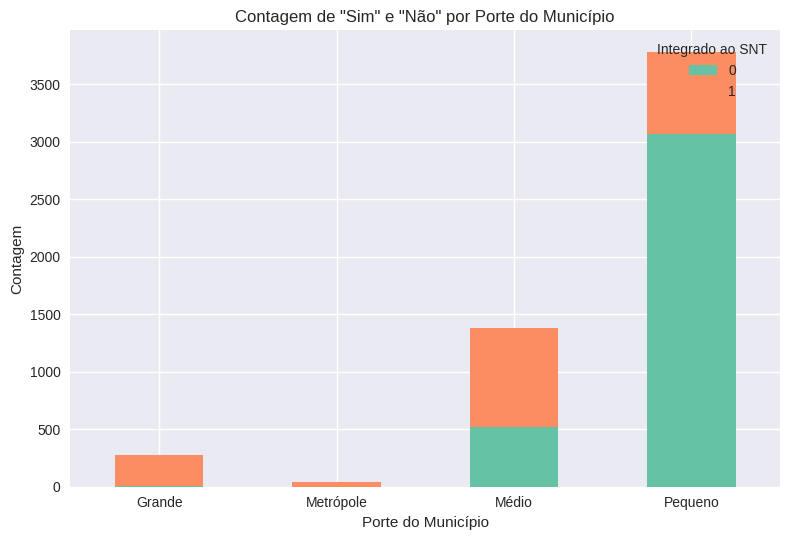

In [26]:
# Contagem absoluta de "Sim" e "Não" por porte
contagem_por_porte = df.groupby('Porte')['Integrado ao SNT'].value_counts().unstack().fillna(0).astype(int)

# Exibindo a tabela
print("Contagem de 'Sim' e 'Não' por porte do município:")
print(contagem_por_porte)
# Gráfico de barras
plt.figure(figsize=(10, 6))
contagem_por_porte.plot(kind='bar', stacked=True)
plt.title('Contagem de "Sim" e "Não" por Porte do Município')
plt.xlabel('Porte do Município')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.legend(title='Integrado ao SNT', loc='upper right')
plt.tight_layout()
plt.show()


# Etapa 2

In [ ]:
# Filtrar municípios com população maior que 100 mil
df_acima_100k = df[df['População'] > 100000] #20000:

In [28]:
# Features e target
X = df_acima_100k[features]
y = df_acima_100k['Integrado ao SNT']

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputação e normalização
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [29]:
# Modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predição e avaliação
y_pred = rf_model.predict(X_test_scaled)
print("\nRelatório de Classificação — População > 100 mil:")
print(classification_report(y_test, y_pred))


Relatório de Classificação — População > 100 mil:
              precision    recall  f1-score   support

           0       0.02      1.00      0.05         1
           1       1.00      0.37      0.53        63

    accuracy                           0.38        64
   macro avg       0.51      0.68      0.29        64
weighted avg       0.98      0.38      0.53        64



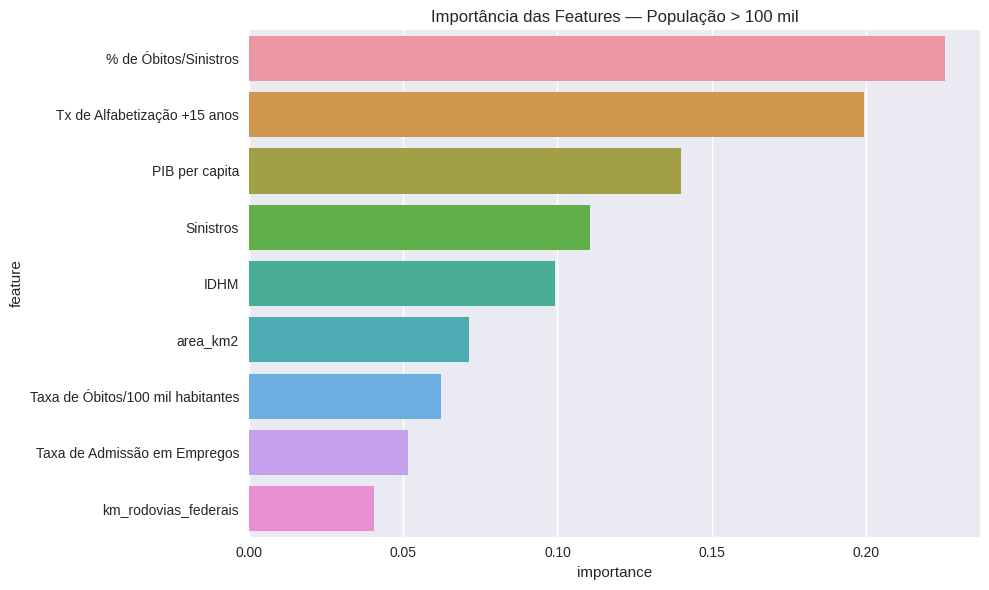

In [30]:

# Importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features — População > 100 mil')
plt.tight_layout()
plt.show()
